In [1]:
!pip3 install pymc3==3.9.3
!pip3 install arviz==0.11.0
!pip3 install pymc
!pip3 install statsmodels

     |████████████████████████████████| 1.9MB 8.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import os
import sys
from plot_lib import set_default

set_default(figsize=(6, 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset

This data contain seven characteristics of 79 urine specimens.The goal of the analysis is to determine
if certain physical characteristics of the urine are related to the formation of calcium oxalate crystals. 

R is an indicator of the presence of a calcium oxalate crystal, so the value of R will be zero or one,
and the explanatory variables or covariates are the specific gravity, the pH reading (this is for acidity), the osmolarity, conductivity, the urea concentration, and finally, the calcium concentration. 

In [3]:
!wget https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/boot/urine.csv

--2021-04-26 21:23:50--  https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/boot/urine.csv
Resolving forge.scilab.org (forge.scilab.org)... 109.7.104.55
Connecting to forge.scilab.org (forge.scilab.org)|109.7.104.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2828 (2.8K) [text/csv]
Saving to: ‘urine.csv.2’

urine.csv.2         100%[===================>]   2.76K  --.-KB/s    in 0s      

2021-04-26 21:23:51 (118 MB/s) - ‘urine.csv.2’ saved [2828/2828]



In [4]:
# Read dataset - Urine
urine = pd.read_csv('urine.csv')
# Checking dataframe
print("The shape of the dataset is: {}".format(urine.shape))
urine.head()

The shape of the dataset is: (79, 8)


,Unnamed: 0,r,gravity,ph,osmo,cond,urea,calc
0,1,0,1.021,4.91,725.0,NaN,443,2.45
1,2,0,1.017,5.74,577.0,20.0,296,4.49
2,3,0,1.008,7.20,321.0,14.9,101,2.36
3,4,0,1.011,5.51,408.0,12.6,224,2.15
4,5,0,1.005,6.52,187.0,7.5,91,1.16


In [5]:
# Describing dataset
urine.pop('Unnamed: 0')
urine.describe()

,r,gravity,ph,osmo,cond,urea,calc
count,79.000000,79.000000,79.000000,78.000000,78.000000,79.000000,79.000000
mean,0.430380,1.018114,6.028481,615.038462,20.901282,266.405063,4.138987
std,0.498293,0.007239,0.724307,238.247685,7.952072,131.254550,3.260051
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000
25%,0.000000,1.012000,5.530000,411.500000,14.375000,160.000000,1.460000
50%,0.000000,1.018000,5.940000,612.500000,21.400000,260.000000,3.160000
75%,1.000000,1.023500,6.385000,797.500000,26.775000,372.000000,5.930000
max,1.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000


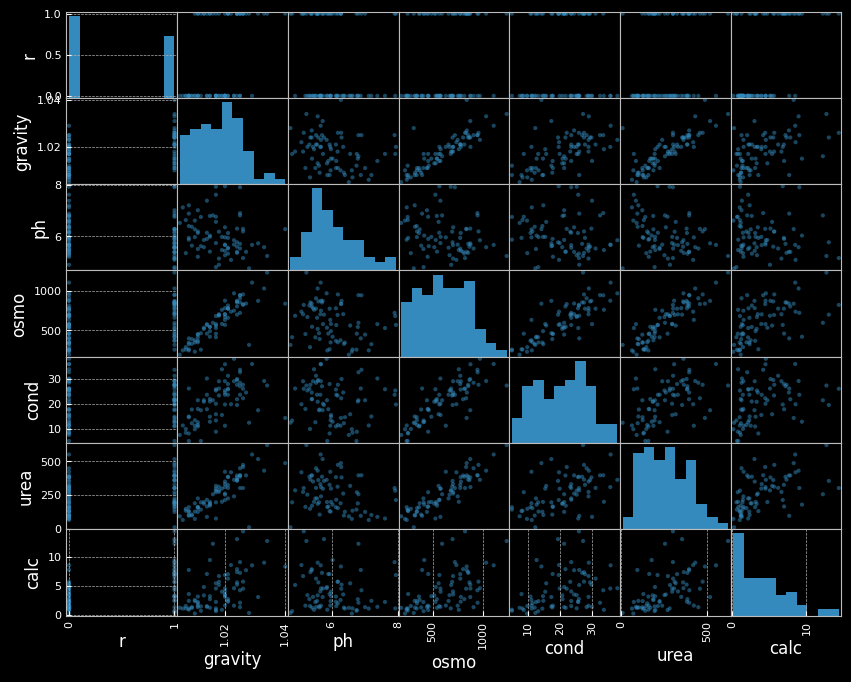

In [6]:
# Dropping NaN
urine = urine.dropna()
# Showing scatter matrix
plt.rc('figure', figsize=(10, 8), dpi=100)
pd.plotting.scatter_matrix(urine, alpha=0.5)
plt.show()
# Get back to defaults
set_default(figsize=(6, 4))

One thing that stands out is that several of these variables are strongly correlated with one another. For example gravity and osmo appear to have a very close linear relationship. Collinearity between $x$ variables in linear regression models can cause trouble for statistical inference. Two correlated variables will compete for the ability to predict the response variable, leading to unstable estimates. This is not a problem for prediction of the response, if prediction is the end goal of the model. But if our objective is to discover how the variables relate to the response, we should avoid collinearity.

### Variable selection

One primary goal of this analysis is to find out which variables are related to the presence of calcium oxalate crystals. This objective is often called “variable selection." One way to do this is to use a linear model where the priors for the $β$ coefficients favor values near 0 (indicating a weak relationship). This way, the burden of establishing association lies with the data. If there is not a strong signal, we assume it doesn’t exist.

Rather than tailoring a prior for each individual $β$ based on the scale its covariate takes values on, it is customary to subtract the mean and divide by the standard deviation for each variable.

$X = \frac{X - \mu}{\sigma}$

In [7]:
from sklearn.preprocessing import StandardScaler

Y = urine.pop('r').to_numpy()
X = urine.to_numpy()
# Scaler object
scaler = StandardScaler()
# Fit scaler
scaler.fit(X)
# scale data
X_scaled = scaler.transform(X)

In [9]:
# Showing that data is centered and scaled
print('The mean for each scaled variable in the dataset is: \n{}\n'.format(np.mean(X_scaled, axis = 0)))
print('The std for each scaled variable in the dataset is: \n{}'.format(np.std(X_scaled, axis = 0)))

The mean for each scaled variable in the dataset is: 
[-4.37456709e-15  2.54100943e-15  1.60045137e-16 -1.64370682e-16
  8.07434927e-17 -8.65108850e-18]

The std for each scaled variable in the dataset is: 
[1. 1. 1. 1. 1. 1.]


### Model

The prior for the $β$ (which we’ll call $b$ in the model) coefficients will be the double exponential (or Laplace) distribution, which as the name implies, is the exponential distribution with tails extending in the positive direction as well as the negative direction, with a sharp peak at 0. We can read more about it in the JAGS manual. The distribution looks like:

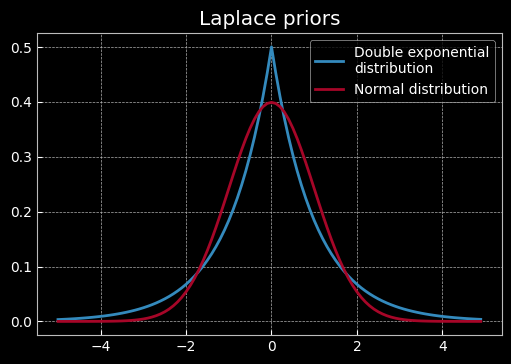

In [10]:
from scipy.stats import norm

def laplace(x, mu, tau):
    return 0.5 * tau * np.exp(-tau * np.abs(x - mu)) 

rv = norm(loc = 0.0, scale = 1.0)
vals = np.arange(-5, 5, 0.1)

plt.plot(vals, laplace(vals, 0.0, 1.0), label = "Double exponential\ndistribution")
plt.plot(vals, rv.pdf(vals), label = "Normal distribution")
plt.legend()
plt.title('Laplace priors')
plt.show()


Recall that for a Bayesian logistic regression, the model should be (in this particular case)

$y_i | \phi_i \stackrel{ind}{\sim} Bern(\phi_i)$

$ \phi_i \rightarrow \text{Probability of success or 1} $

$ \mathbb{E}(y_i) = \phi_i = \frac{1}{1 + \exp^{-(\beta_0 + \beta_1 X_{1,i} + ... + \beta_6 X_{6, i})}}$

$\beta_1, ..., \beta_6 \sim \text{LaPlace}(0.0, \frac{1}{\sqrt{2}})$

$\beta_0 \sim \mathcal{N}(0, 25)$

In [30]:
from scipy.special import logit

with pm.Model() as lr:
    # Definen priors of parameters
    b_0 = pm.Normal('b0', 0, 25) # Non informative prior for intercept
    ### We need 6 parameters, therefore, 6 "slopes"
    b_1 = pm.Laplace('b1', mu = 0.0, b = 1 / np.sqrt(2.0)) # Variance of 1 (gravity)
    b_2 = pm.Laplace('b2', mu = 0.0, b = 1 / np.sqrt(2.0)) # Variance of 1 (ph)
    b_3 = pm.Laplace('b3', mu = 0.0, b = 1 / np.sqrt(2.0)) # Variance of 1 (osmo)
    b_4 = pm.Laplace('b4', mu = 0.0, b = 1 / np.sqrt(2.0)) # Variance of 1 (cond)
    b_5 = pm.Laplace('b5', mu = 0.0, b = 1 / np.sqrt(2.0)) # Variance of 1 (urea)
    b_6 = pm.Laplace('b6', mu = 0.0, b = 1 / np.sqrt(2.0)) # Variance of 1 (calc)
    
    x_ = pm.Data('features', X_scaled) # a data container, can be changed

    logit_p = pm.math.sigmoid(b_0 + b_1 * x_[:, 0] + b_2 * x_[:, 1] + b_3 * x_[:, 2] + b_4 * x_[:, 3] + b_5 * x_[:, 4] + b_6 * x_[:, 5])

    # Likelihood
    obs = pm.Bernoulli('likelihood', p = logit_p, observed = Y)

In [31]:
with lr:
    # Use MCMC to sample 10000 samples
    trace = pm.sample(10000, tune = 1000)
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b6, b5, b4, b3, b2, b1, b0]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 51 seconds.


### MCMC convergence diagnostic


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


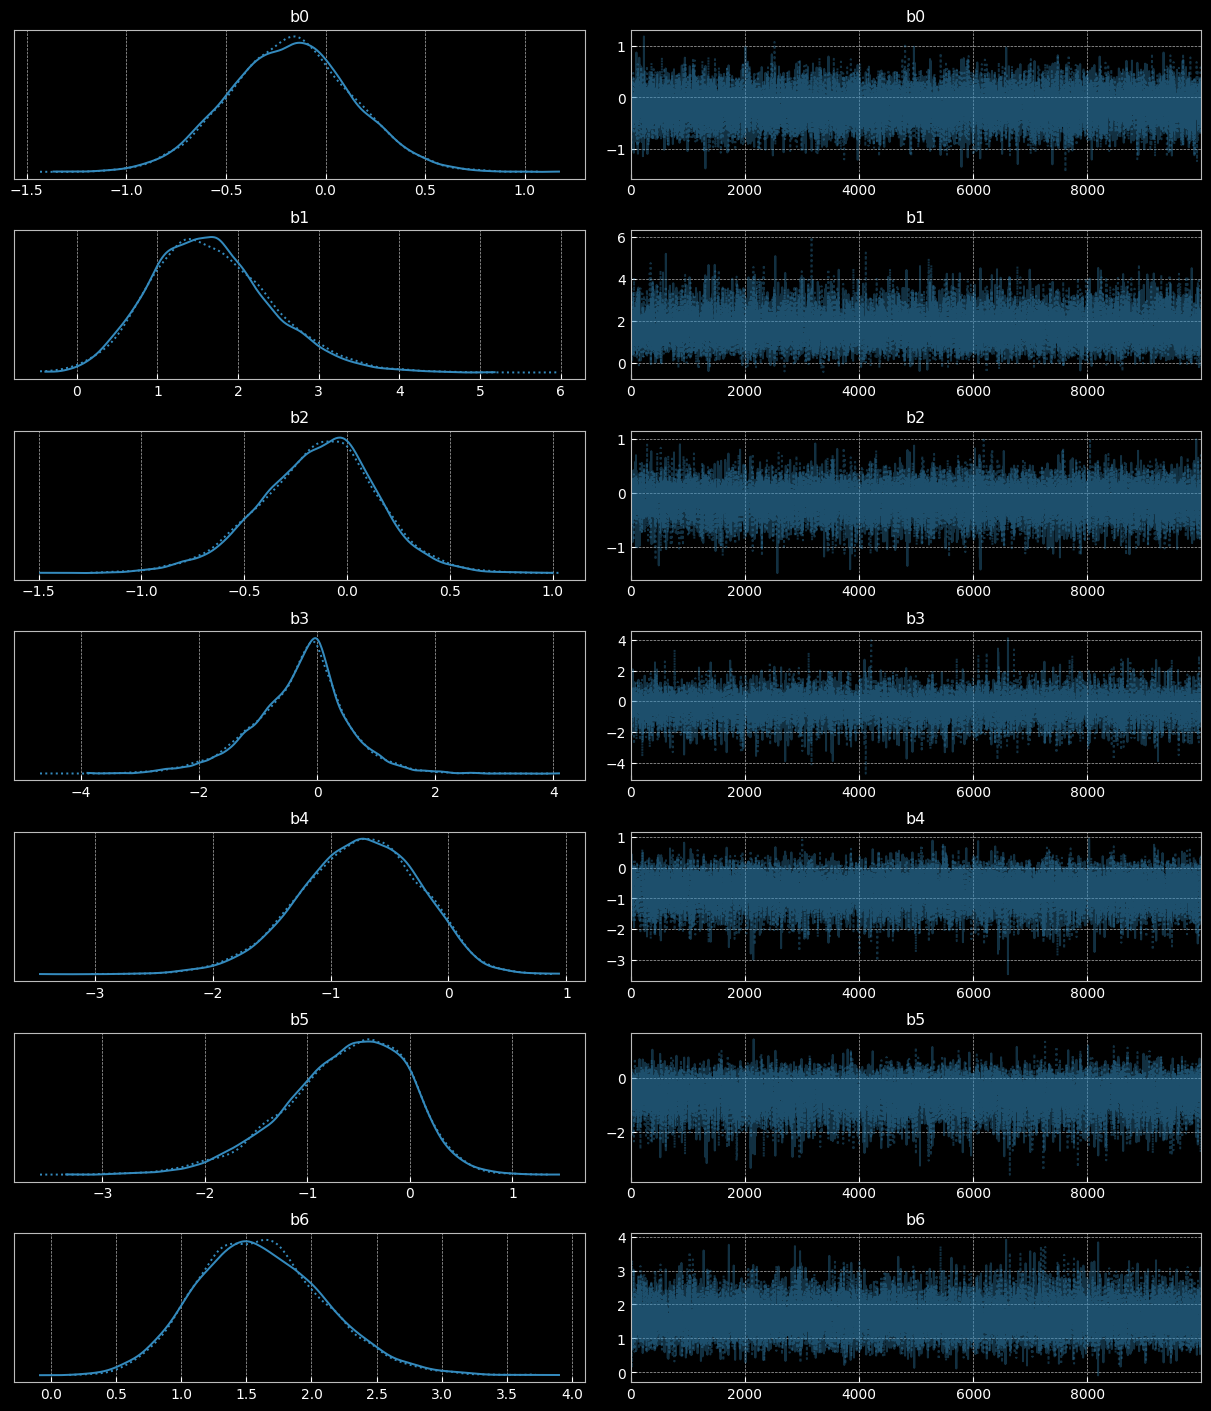

In [32]:
# Plotting posterior distribution of mu
az.plot_trace(trace)
plt.show()

In [33]:
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,-0.177,0.311,-0.761,0.408,0.003,0.002,14379.0,11475.0,14414.0,11573.0,1.0
b1,1.670,0.752,0.333,3.110,0.008,0.006,9422.0,8342.0,9896.0,9949.0,1.0
b2,-0.142,0.287,-0.700,0.391,0.002,0.002,13738.0,8961.0,14024.0,12237.0,1.0
b3,-0.295,0.804,-1.987,1.135,0.008,0.007,9488.0,6825.0,9978.0,9363.0,1.0
b4,-0.763,0.509,-1.726,0.143,0.005,0.004,10223.0,9805.0,10327.0,11924.0,1.0
b5,-0.619,0.603,-1.804,0.408,0.006,0.005,8650.0,7704.0,9187.0,9810.0,1.0
b6,1.611,0.492,0.708,2.522,0.004,0.003,12611.0,11766.0,12896.0,12059.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


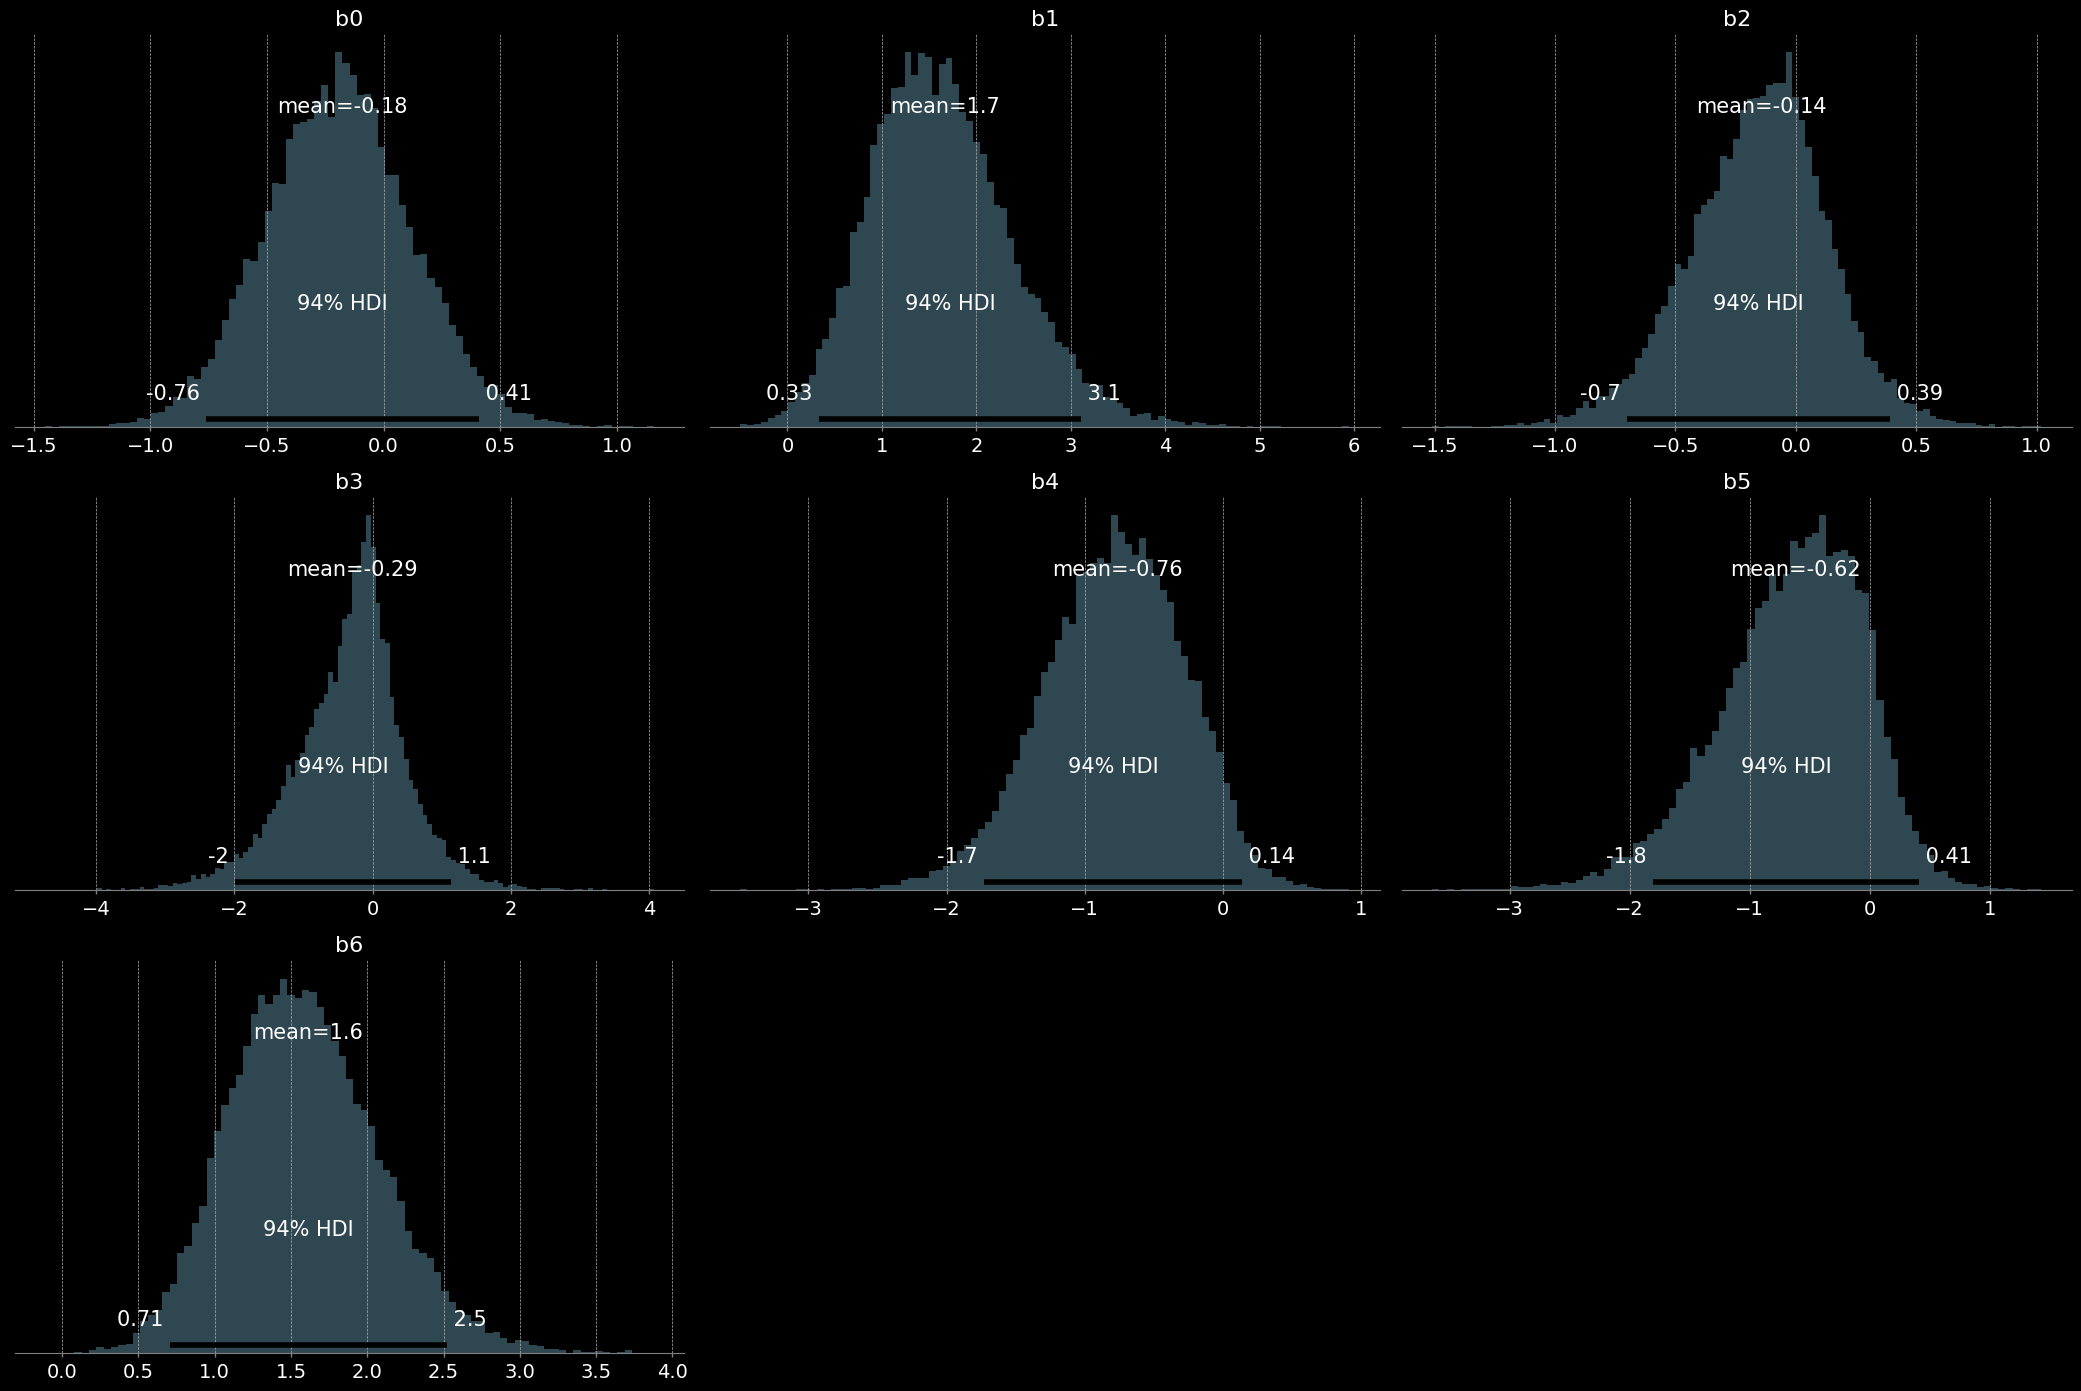

In [34]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

It is clear that the coefficients for variables $gravity$, $cond$ (conductivity), and $calc$ (calcium concentration) are not 0. The posterior distribution for the coefficient of $osmo$ (osmolarity) looks like the prior, and is almost centered on $0$ still, so we’ll conclude that osmo is not a strong predictor of calcium oxalate crystals. The same goes for $ph$.

$urea$ (urea concentration) appears to be a borderline case. However, if we refer back to our correlations among the variables, we see that urea is highly correlated with gravity, so we opt to remove it.

Our second model looks like this:


$y_i | \phi_i \stackrel{ind}{\sim} Bern(\phi_i)$

$ \phi_i \rightarrow \text{Probability of success or 1} $

$ \mathbb{E}(y_i) = \phi_i = \frac{1}{1 + \exp^{-(\beta_0 + \beta_1 X_{1,i} + ... + \beta_3 X_{3, i})}}$

$\beta_1, ..., \beta_3 \sim \mathcal{N}(0, 25)$

$\beta_0 \sim \mathcal{N}(0, 25)$

In [37]:
with pm.Model() as lr_2:
    # Definen priors of parameters
    b_0 = pm.Normal('b0', 0, 25) # Non informative prior for intercept
    ### We need 6 parameters, therefore, 3 "slopes"
    b_1 = pm.Normal('b1', 0, 25) # Variance of 1 (gravity)
    b_2 = pm.Normal('b2', 0, 25) # Variance of 1 (cond)
    b_3 = pm.Normal('b3', 0, 25) # Variance of 1 (calc)
    
    x_ = pm.Data('features', X_scaled) # a data container, can be changed

    logit_p = pm.math.sigmoid(b_0 + b_1 * x_[:, 0] + b_2 * x_[:, 3] + b_3 * x_[:, 5])

    # Likelihood
    obs = pm.Bernoulli('likelihood', p = logit_p, observed = Y)

In [38]:
with lr_2:
    # Use MCMC to sample 15000 samples
    trace_2 = pm.sample(15000, tune = 5000)
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b3, b2, b1, b0]


Sampling 2 chains for 5_000 tune and 15_000 draw iterations (10_000 + 30_000 draws total) took 47 seconds.


### MCMC convergence diagnostic


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


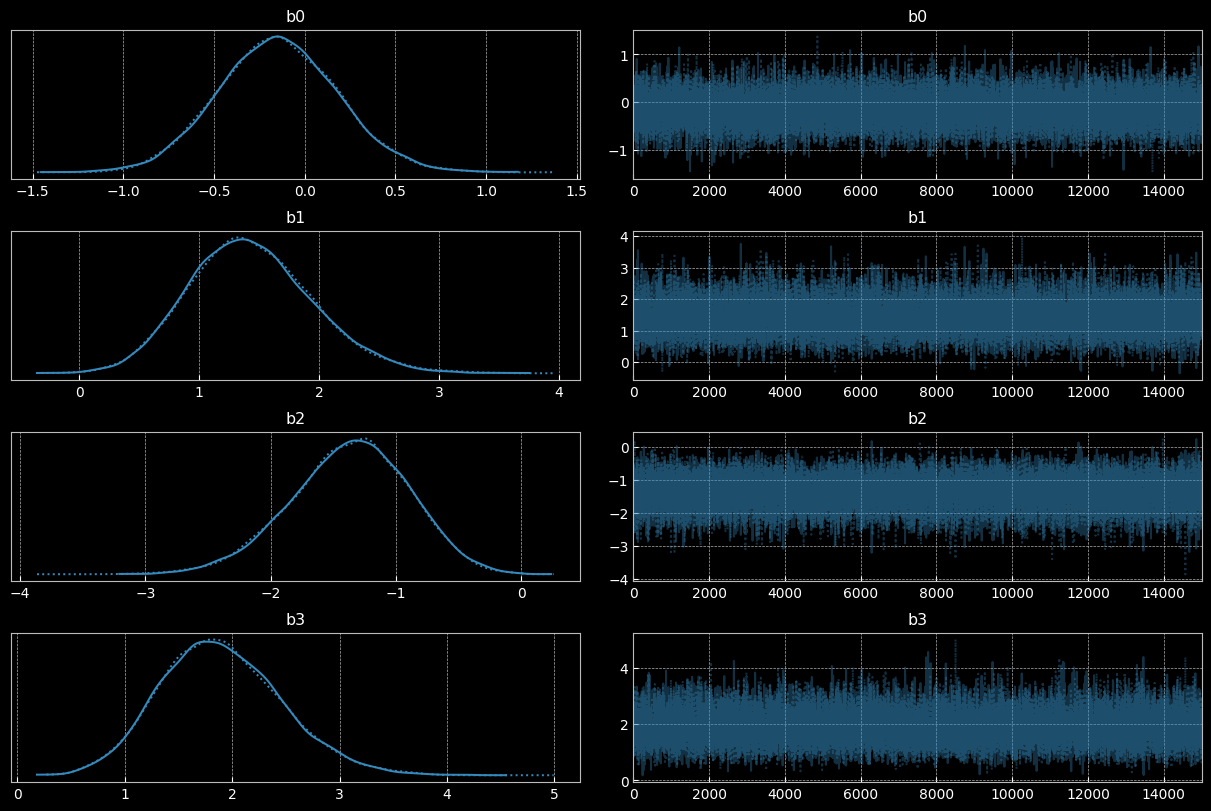

In [39]:
# Plotting posterior distribution of mu
az.plot_trace(trace_2)
plt.show()

In [40]:
pm.summary(trace_2)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,-0.147,0.329,-0.762,0.474,0.002,0.002,22357.0,17909.0,22441.0,19371.0,1.0
b1,1.432,0.518,0.486,2.423,0.004,0.003,15780.0,14948.0,16064.0,17370.0,1.0
b2,-1.369,0.472,-2.253,-0.492,0.004,0.003,15600.0,14900.0,15761.0,17084.0,1.0
b3,1.898,0.566,0.859,2.970,0.004,0.003,18600.0,17219.0,19152.0,17612.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


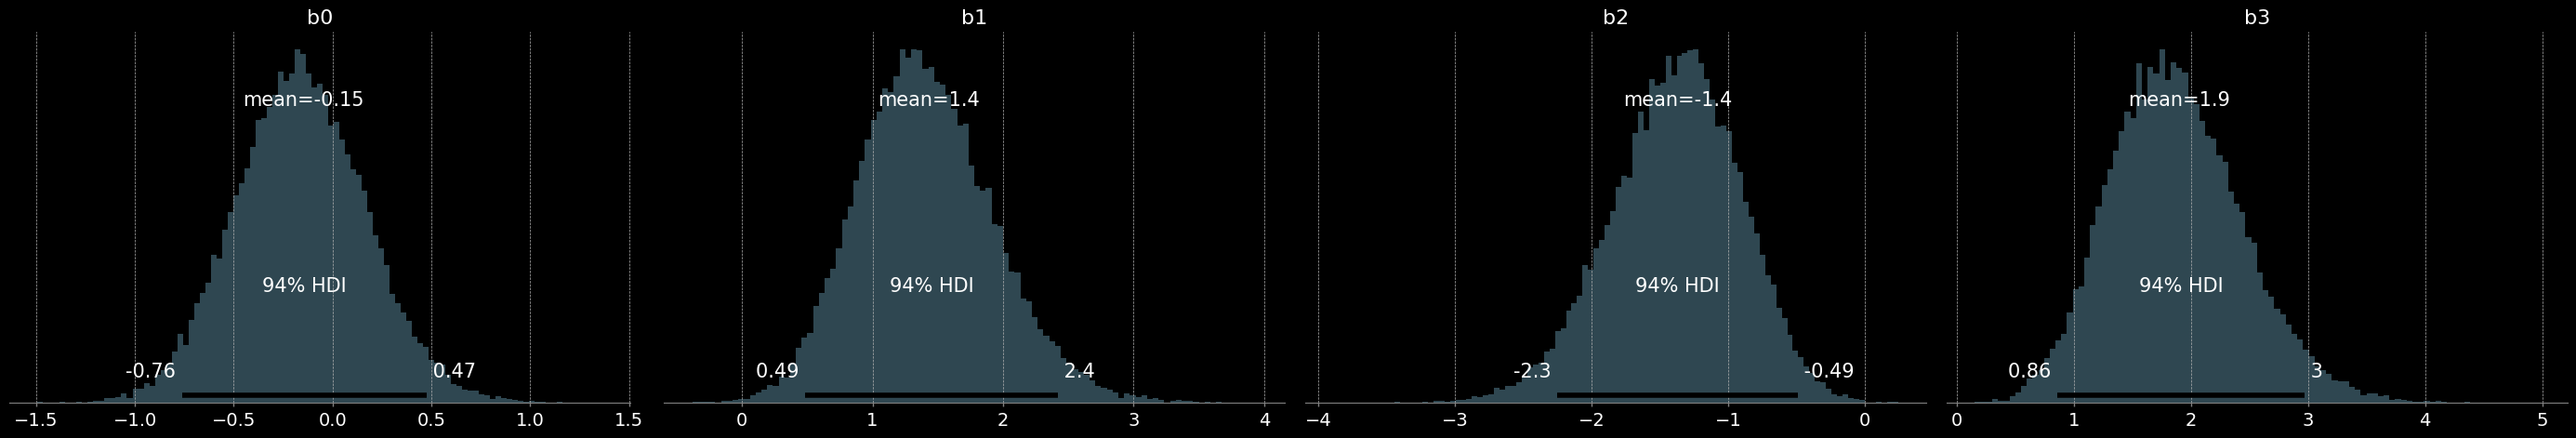

In [41]:
az.plot_posterior(trace_2, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

### Inference with the Second model

In [44]:
with lr_2:
    pm.set_data({'features': X_scaled})
    posterior = pm.sample_posterior_predictive(trace_2)

y_pred = posterior['likelihood']
print('The shape of the observations is: {}'.format(y_pred.shape))

The shape of the observations is: (30000, 77)


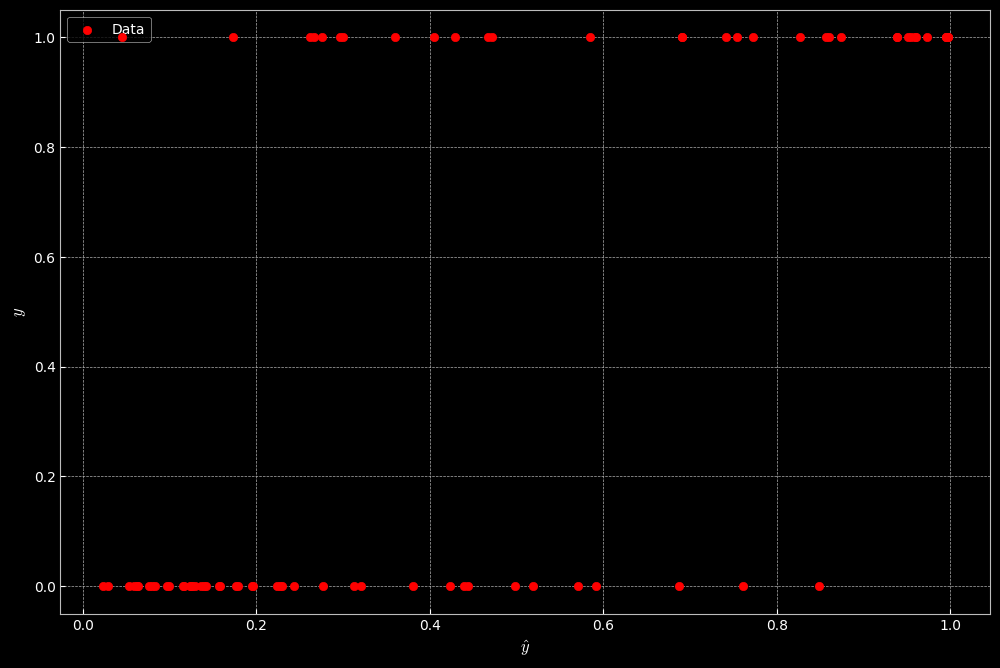

In [54]:
# Plotting the predictions
y_mean = y_pred.mean(axis=0).ravel()
y_std = y_pred.std(axis=0).ravel()
plt.figure(figsize=(12, 8))
plt.scatter(y_mean, Y, c='red', zorder=10, label='Data')
plt.xlabel('$\hat{y}$')
plt.ylabel('$y$')
plt.legend(loc='upper left')
plt.show()

Suppose we choose a cutoff for these predicted probabilities. If the model tells us the probability is higher than $0.5$, we will classify the observation as a $1$ and if it is less than $0.5$, we will classify it as a $0$. That way the model classifies each data point. Now we can tabulate these classifications against the truth to see how well the model predicts the original data.

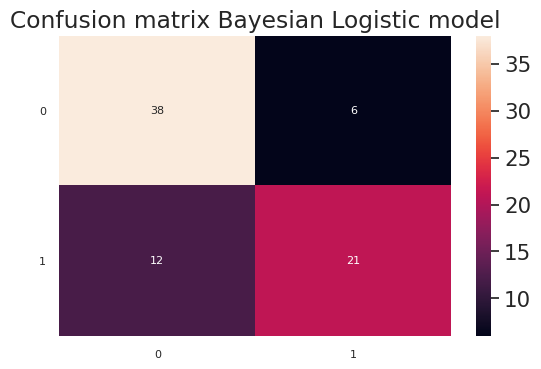

The accuracy of the model is: 0.7662337662337663


In [65]:
from sklearn.metrics import confusion_matrix

# Thresholding values
y_tresh = y_mean > 0.5

cm = confusion_matrix(Y, y_tresh)

# Matplotlib plot
_, ax = plt.subplots()
# Confusion matrix as Pandas DF
df_cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])

sns.set(font_scale = 1.4) # For label size
sns.heatmap(df_cm, annot_kws={"size": 8}, annot = True) # Font size
# Plot configuration
ax.set_xticklabels(['0', '1'],rotation='horizontal',size = 8)
ax.set_yticklabels(['0', '1'],rotation='horizontal',size = 8)
ax.set_title('Confusion matrix Bayesian Logistic model')

plt.tight_layout()
plt.show()

print('The accuracy of the model is: {}'.format(np.sum(y_tresh == Y) / len(Y)))

The correct classification rate is about 76%, not too bad, but not great.